In [2]:
import pickle
from datetime import datetime as dtdt

import attrs
import numpy as np

from hetero.config import DTYPE, AlgoConfig, DataGenConfig, GroupingConfig
from hetero.datagen import generate_data_from_config, extract_first_n_order
from hetero.policies import AlternativePolicy
from hetero.tasks import (
    beta_estimate_from,
    beta_estimate_from_e2e_learning,
    beta_estimate_from_nongrouped,
    compute_UV_truths,
    compute_V_estimate,
)
from hetero.utils import generate_decay_matrix

In [3]:
MAX_LEGENDRE_ORDER = 4
TRUE_LEGENDRE_ORDER = 2
assert TRUE_LEGENDRE_ORDER < MAX_LEGENDRE_ORDER

SEED = 8888 #1818 

coeff_rand = np.random.RandomState(SEED) #(7531)

group_reward_coeff = np.array(
    [
        [-2, 2, 2, -2],
        [2, -2, -2, 2],
    ],
    dtype=DTYPE,
)

action_reward_coeff = [-1, 1]

FEATURE_TYPE = "LEGENDRE"
TRANS = "NORMCDF"
NOISE = "STUDENT"

In [4]:
FEATURE_TYPE = "LEGENDRE"
TRANS = "NORMCDF"
NOISE = "STUDENT"

data_config_init = dict(
    num_trajectories=100,
    num_time_steps=40,
    group_reward_coeff_override=group_reward_coeff,
    action_reward_coeff=action_reward_coeff,
    num_burnin_steps=100,
    basis_expansion_method=FEATURE_TYPE,
    transformation_method=TRANS,
    add_intercept_column=True,
    noise_type=NOISE,
    noise_student_degree=4,
)

time_tag = dtdt.now().strftime("%Y%m%d_%H-%M-%S")
tag = f'N={data_config_init["num_trajectories"]}_T={data_config_init["num_time_steps"]}_{time_tag}'
RESULT_FILE = f"hetero/data/{FEATURE_TYPE}_{TRANS}_{NOISE}_result_20230528_{tag}.pkl"
print("result file name =", RESULT_FILE)
SAVE_RESULT = False
if not SAVE_RESULT:
    print("Result will NOT be saved, only use this for experimental runs!!!")

result file name = hetero/data/LEGENDRE_NORMCDF_STUDENT_result_20230528_N=100_T=40_20230602_21-49-24.pkl
Result will NOT be saved, only use this for experimental runs!!!


=====================================================================================================

In [5]:
algo_config = AlgoConfig(
    max_num_iters=10,
    gam=2.7,
    lam=2.0,
    rho=2.0,
    #should_remove_outlier=True,
    #outlier_lower_perc=2,
    #outlier_upper_perc=98,
    nu_coeff=0,
    delta_coeff=0,
    use_group_wise_regression_init=True,
)

pi_eval = AlternativePolicy(2)

grouping_config = GroupingConfig()

In [6]:
FULL_DATA_CONFIG = DataGenConfig(seed=SEED, **data_config_init)
FULL_DATA = generate_data_from_config(FULL_DATA_CONFIG)

In [7]:
print(FULL_DATA.current_features[:3, :])
print(FULL_DATA.next_features[:3, :])

[[0.23030634 0.37052292 0.62422955 0.36836544 1.        ]
 [0.86754966 0.45787346 0.91378623 0.31447265 1.        ]
 [0.5628606  0.2707383  0.32188046 0.5236095  1.        ]]
[[0.91535705 0.38602734 0.9901991  0.35415715 1.        ]
 [0.1894819  0.20580925 0.745723   0.6953881  1.        ]
 [0.9999619  0.57452893 1.         0.3274263  1.        ]]


In [8]:
beta_learned_list = []
print("FULL_FEATURE_SHAPE=", FULL_DATA.current_features.shape)
for order in range(1, MAX_LEGENDRE_ORDER + 1):
    data = extract_first_n_order(FULL_DATA, order, FULL_DATA_CONFIG)
    print("FEATURE_SHAPE=", data.current_features.shape)
    beta_learned_list.append(
        beta_estimate_from_e2e_learning(data, algo_config, grouping_config, pi_eval)
    )

FULL_FEATURE_SHAPE= (8000, 5)
FEATURE_SHAPE= (8000, 3)
new_labels.length=8000 matches number of records
beta_solver, min eigen of left matrix = 1.0
MCPImpl: num_above=11891, num_below=8009
beta_solver, min eigen of left matrix = 1.0
MCPImpl: num_above=15124, num_below=4776
beta_solver, min eigen of left matrix = 1.0
MCPImpl: num_above=11905, num_below=7995
beta_solver, min eigen of left matrix = 1.0
MCPImpl: num_above=15149, num_below=4751
beta_solver, min eigen of left matrix = 1.0
MCPImpl: num_above=11902, num_below=7998
beta_solver, min eigen of left matrix = 1.0
MCPImpl: num_above=15144, num_below=4756
beta_solver, min eigen of left matrix = 1.0
MCPImpl: num_above=11898, num_below=8002
beta_solver, min eigen of left matrix = 1.0
MCPImpl: num_above=15153, num_below=4747
beta_solver, min eigen of left matrix = 1.0
MCPImpl: num_above=11910, num_below=7990
beta_solver, min eigen of left matrix = 1.0
MCPImpl: num_above=15139, num_below=4761
kmeans center = [[ 0.88474234 -3.10361793  1.7

In [9]:
for order, beta in zip(range(1, 11), beta_learned_list):
    print(order, beta.mean_sqrt_residuals)

1 [0.8977987776869236, 0.9120894214616271]
2 [0.7445468022332403, 0.7532586777085729]
3 [0.742769255646827, 0.7351374757829313]
4 [0.742769255646827, 0.7351374757829313]


In [10]:
'''
1 [2.802960947774569, 3.4396761665808695]
2 [2.461491873623194, 2.5502559853495135]
3 [2.4895700120539446, 2.693757645047646]
4 [2.5411310150213864, 2.6872455876229497]
'''

'\n1 [2.802960947774569, 3.4396761665808695]\n2 [2.461491873623194, 2.5502559853495135]\n3 [2.4895700120539446, 2.693757645047646]\n4 [2.5411310150213864, 2.6872455876229497]\n'

In [14]:
res = np.array([
    [0.8977987776869236, 0.9120894214616271],
    [0.7445468022332403, 0.7532586777085729],
    [0.742769255646827, 0.7351374757829313],
    [0.742769255646827, 0.7351374757829313]
])
res.shape

(4, 2)

In [16]:
x = [1,2,3,4]
y = np.mean(res**2, axis=1)

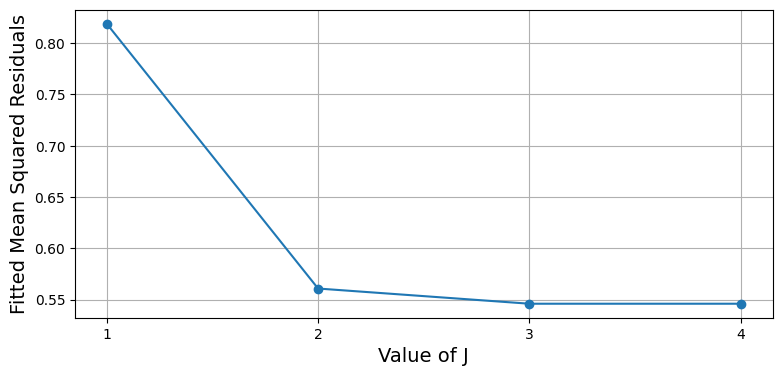

In [25]:
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.figure(figsize=(9,4))
plt.set_cmap('tab20')
plt.plot(x, y, marker='o')

#plt.title('Fitted Mean Squared Residuals V.S. J', fontsize=14)
plt.xticks(x)
plt.xlabel('Value of J', fontsize=14)
plt.ylabel('Fitted Mean Squared Residuals', fontsize=14)
plt.grid(True)

plt.savefig(f'results/differ_J.pdf', bbox_inches='tight')

In [ ]:
x = [1,2,3,4]
y_msr = np.array([0.7984360395717708, 0.6478314309268901, 1.4320189920821786, 3.0909050260042616])
y_sig = np.arragy([0.022312958034004727, 0.017965336241819896, 0.03971506875035885, 0.08493631791635486])